<a href="https://colab.research.google.com/github/lukmangit24/Time-Series-Forecasting/blob/main/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# library

In [70]:
from sklearn.utils.validation import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from zipfile import ZipFile
import glob

# Eksplorasi Data




In [71]:
with ZipFile('/content/dataset extra day 7 zip.zip', 'r') as z:
    z.extractall('data_2019')

# 2) Baca semua CSV otomatis
# Changed glob path to look in /content/ where CSVs are directly available
all_files = glob.glob("/content/data_2019/**/*.csv", recursive=True)

df_list = [pd.read_csv(f) for f in all_files]
df = pd.concat(df_list, ignore_index=True)

print("Total rows:", df.shape[0])
df.head()

Total rows: 186850


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,248151,AA Batteries (4-pack),4,3.84,09/17/19 14:44,"380 North St, Los Angeles, CA 90001"
1,248152,USB-C Charging Cable,2,11.95,09/29/19 10:19,"511 8th St, Austin, TX 73301"
2,248153,USB-C Charging Cable,1,11.95,09/16/19 17:48,"151 Johnson St, Los Angeles, CA 90001"
3,248154,27in FHD Monitor,1,149.99,09/27/19 07:52,"355 Hickory St, Seattle, WA 98101"
4,248155,USB-C Charging Cable,1,11.95,09/01/19 19:03,"125 5th St, Atlanta, GA 30301"


In [72]:

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 8.6+ MB


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
count,186305,186305,186305,186305,186305,186305
unique,178438,20,10,24,142396,140788
top,Order ID,USB-C Charging Cable,1,11.95,Order Date,Purchase Address
freq,355,21903,168552,21903,355,355


# Pembersihan Data

## missing value

In [73]:
df.isnull().sum()

,0
Order ID,545
Product,545
Quantity Ordered,545
Price Each,545
Order Date,545
Purchase Address,545


In [74]:
df_clean = df.dropna().copy()
df_clean.isnull().sum()

,0
Order ID,0
Product,0
Quantity Ordered,0
Price Each,0
Order Date,0
Purchase Address,0


## convert data

In [75]:
# 4) Parse order_date
df_clean['Order Date'] = pd.to_datetime(
    df_clean['Order Date'],
    errors='coerce'
)


# 5) Convert numeric fields (quantity, price) and compute sales
df_clean['Quantity Ordered'] = pd.to_numeric(df['Quantity Ordered'], errors='coerce')
df_clean['Price Each'] = pd.to_numeric(df['Price Each'], errors='coerce')


/tmp/ipython-input-4150865042.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['Order Date'] = pd.to_datetime(


In [76]:
df_clean = df_clean.dropna(subset=['Order Date', 'Quantity Ordered', 'Price Each'])

In [77]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185950 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  object        
 1   Product           185950 non-null  object        
 2   Quantity Ordered  185950 non-null  float64       
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Purchase Address  185950 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 9.9+ MB


## New Features

In [78]:
df_clean["City"] = df_clean["Purchase Address"].apply(lambda x: x.split(",")[1].strip())
df_clean.head(1)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,City
0,248151,AA Batteries (4-pack),4.0,3.84,2019-09-17 14:44:00,"380 North St, Los Angeles, CA 90001",Los Angeles


In [79]:
df_clean['Revenue'] = df_clean['Quantity Ordered'] * df_clean['Price Each']
df_clean.head(1)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,City,Revenue
0,248151,AA Batteries (4-pack),4.0,3.84,2019-09-17 14:44:00,"380 North St, Los Angeles, CA 90001",Los Angeles,15.36


In [80]:
df_clean['date'] = df_clean['Order Date'].dt.date
df_clean['day'] = df_clean['Order Date'].dt.floor('d')
df_clean['week'] = df_clean['Order Date'].dt.to_period("W").apply(lambda r: r.start_time)
df_clean['month'] = df_clean['Order Date'].dt.to_period("M").apply(lambda r: r.start_time)
df_clean["Hour"] = df_clean["Order Date"].dt.hour
df_clean[['Order Date','day','week','month','Hour']].head()

,Order Date,day,week,month,Hour
0,2019-09-17 14:44:00,2019-09-17,2019-09-16,2019-09-01,14
1,2019-09-29 10:19:00,2019-09-29,2019-09-23,2019-09-01,10
2,2019-09-16 17:48:00,2019-09-16,2019-09-16,2019-09-01,17
3,2019-09-27 07:52:00,2019-09-27,2019-09-23,2019-09-01,7
4,2019-09-01 19:03:00,2019-09-01,2019-08-26,2019-09-01,19


# Analisis Tren dan Pola

<Axes: title={'center': 'Daily Revenue Trend'}, xlabel='day'>

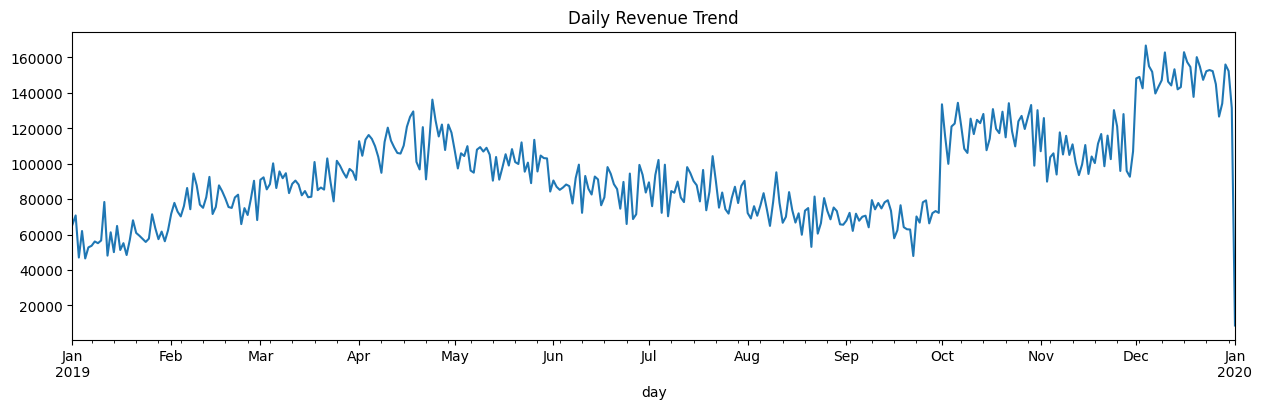

In [81]:
daily_revenue = df_clean.groupby('day')['Revenue'].sum()

daily_revenue.plot(figsize=(15,4), title="Daily Revenue Trend")

Perkembangan Sales Sepanjang 2019

- Awal tahun (Jan–Feb):
Penjualan masih stabil dan cenderung rendah, sekitar 50–80 ribu per hari.

- Naik signifikan (Maret–Juni):
Penjualan meningkat tajam hingga mencapai 120–140 ribu per hari.

- Penurunan (Juli–September):
Terjadi penurunan stabil ke kisaran 70–90 ribu per hari.

- Kenaikan besar (November–Desember):
Terjadi lonjakan pada event musiman

Pola naik → turun → naik lagi yang menunjukkan adanya faktor musiman kuat.

Akhir tahun adalah periode paling menguntungkan.

<Axes: title={'center': 'Weekly Revenue Trend'}, xlabel='week'>

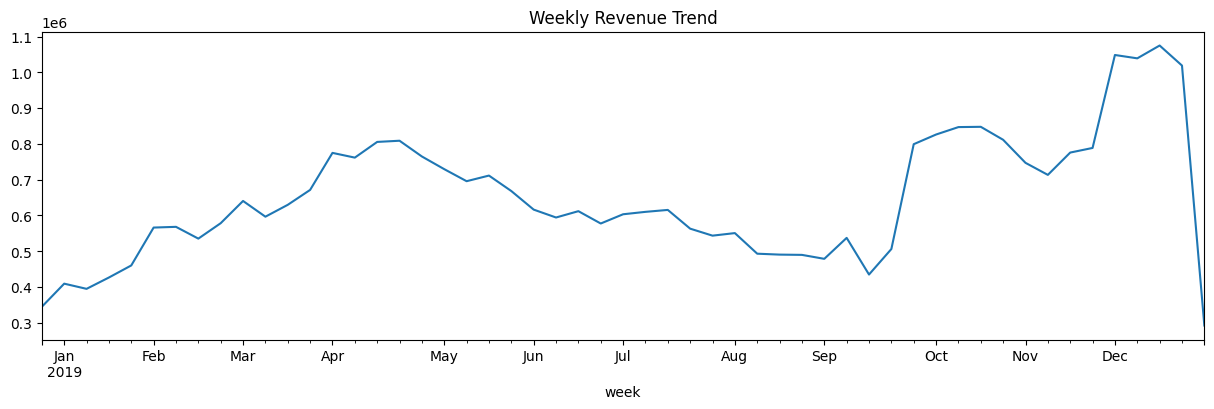

In [82]:
weekly_revenue= df_clean.groupby('week')['Revenue'].sum()

weekly_revenue.plot(figsize=(15,4), title="Weekly Revenue Trend")

<Axes: title={'center': 'Monthly Revenue Trend'}, xlabel='month'>

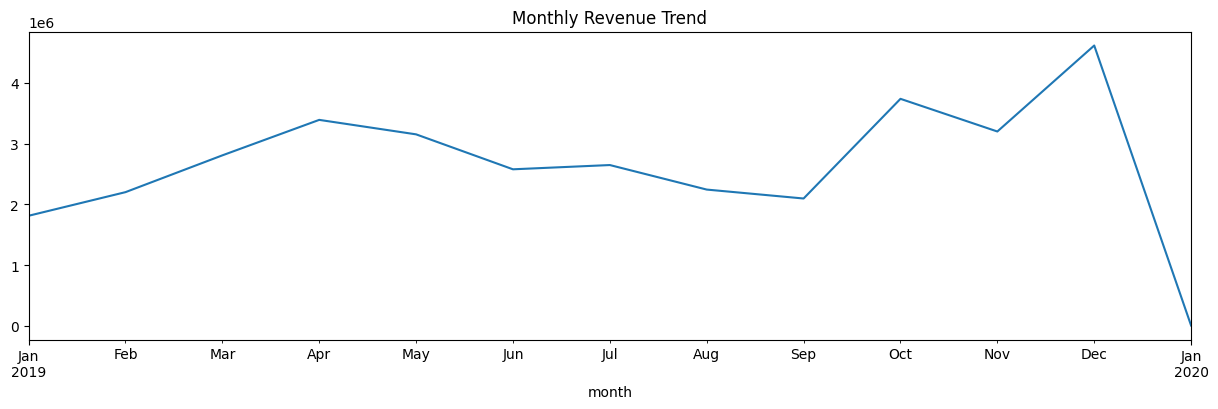

In [83]:
monthly_revenue = df_clean.groupby('month')['Revenue'].sum()

monthly_revenue.plot(figsize=(15,4), title="Monthly Revenue Trend")

In [84]:
df_clean['DayOfWeek'] = df_clean['Order Date'].dt.day_name()
weekly = df_clean.groupby('DayOfWeek')['Revenue'].sum().reindex([
    'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'
])
print(weekly)


DayOfWeek
Monday       4883326.72
Tuesday      5087956.78
Wednesday    4988822.26
Thursday     4839465.16
Friday       4855938.38
Saturday     4904357.01
Sunday       4932169.66
Name: Revenue, dtype: float64


#Pembuatan Model Forecasting

## Uji ADF

In [85]:
ts = daily_revenue

adf_result = adfuller(ts)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -2.3508591590746564
p-value: 0.1560888501412367


In [86]:
#lakukan different karena  pvalue sebelumnya > 0.05

ts_seasonal = ts.diff(7).dropna()
adf7 = adfuller(ts_seasonal)
print(f'ADF Statistic: {adf7[0]}')
print(f'p-value: {adf7[1]}')

ADF Statistic: -3.371217997606885
p-value: 0.011980065073195526


## Membuat model

In [87]:
train = ts_seasonal.iloc[:-30]
test = ts_seasonal.iloc[-30:]

In [88]:
model_arima = ARIMA(train, order=(5,1,2))
model_arima_fit = model_arima.fit()

forecast_arima = model_arima_fit.forecast(steps=len(test))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

In [89]:
model_es = ExponentialSmoothing(
    train,
    trend='add',
    seasonal=None,
    initialization_method='estimated'
).fit()

forecast_es = model_es.forecast(steps=len(test))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [90]:
sarima_model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_model_fit = sarima_model.fit() # Fit the model

forecast_sarima = sarima_model_fit.forecast(steps=len(test))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [91]:
mape_arima = mean_absolute_percentage_error(test, forecast_arima)
mape_es = mean_absolute_percentage_error(test, forecast_es)
mape_sarima = mean_absolute_percentage_error(test, forecast_sarima)



## Evaluasi Model

In [92]:
mape_results = {
    "ARIMA": mape_arima,
    "Exponential Smoothing": mape_es,
    "SARIMA": mape_sarima
}


for model, mape in mape_results.items():
    print(f"{model}  →  MAPE = {mape}")

best_model = min(mape_results, key=mape_results.get)
best_mape = mape_results[best_model]

print("\n Model Terbaik Berdasarkan MAPE:")
print(f" {best_model} (MAPE = {best_mape})")


ARIMA  →  MAPE = 1.5305422209783233
Exponential Smoothing  →  MAPE = 6.031932483092095
SARIMA  →  MAPE = 7.018824244263625

 Model Terbaik Berdasarkan MAPE:
 ARIMA (MAPE = 1.5305422209783233)


Dengan akurasi 98.5% (MAPE 1.53%), prediksi ini dapat digunakan untuk:

- Menentukan kapan harus restock

- Menentukan jumlah stok optimal per minggu

- Mengurangi biaya overstock dan understock

# pertanyaan yang harus dijawab

## 1.	Hitunglah total revenue, jumlah order, dan jumlah barang yang terjual sepanjang tahun 2019. Selain itu, hitung rata-rata jumlah barang yang dibeli per transaksi dan rata-rata spending per transaksi.

In [93]:
# 1. TOTAL REVENUE 2019
total_revenue = df_clean['Revenue'].sum()


# 2. JUMLAH ORDER (JUMLAH TRANSAKSI)
total_orders = df_clean['Order ID'].nunique()

# 3. JUMLAH BARANG TERJUAL
total_quantity = df_clean['Quantity Ordered'].sum()


# 4. RATA-RATA BARANG PER TRANSAKSI
df_order_qty = df_clean.groupby('Order ID')['Quantity Ordered'].sum()
avg_items_per_order = df_order_qty.mean()


# 5. RATA-RATA SPENDING PER TRANSAKSI
df_order_rev = df_clean.groupby('Order ID')['Revenue'].sum()
avg_spending_per_order = df_order_rev.mean()


print("Total Revenue 2019: $", round(total_revenue, 2))
print("Total Orders:", total_orders)
print("Total Quantity Sold:", total_quantity)
print("Avg Items per Order:", round(avg_items_per_order, 2))
print("Avg Spending per Order: $", round(avg_spending_per_order, 2))

Total Revenue 2019: $ 34492035.97
Total Orders: 178437
Total Quantity Sold: 209079.0
Avg Items per Order: 1.17
Avg Spending per Order: $ 193.3


## 2.	Hitunglah jumlah order dan GMV yang diperoleh dengan rentang waktu berikut:
a.	Harian
b.	Mingguan
c.	Bulanan

Catatan: GMV dihitung berdasarkan total spending yang dilakukan customer dengan memperhitungkan semua biaya dan diskon yang dibayarkan customer.


In [94]:
# a. Harian
daily = df_clean.groupby("day").agg(
    total_orders=("Order ID", "nunique"),
    total_gmv=("Revenue", "sum")
).reset_index()

# b. Mingguan
weekly = df_clean.groupby("week").agg(
    total_orders=("Order ID", "nunique"),
    total_gmv=("Revenue", "sum")
).reset_index()

# c. Bulanan
monthly = df_clean.groupby("month").agg(
    total_orders=("Order ID", "nunique"),
    total_gmv=("Revenue", "sum")
).reset_index()


# rata-rata gmv
avg_daily_gmv = daily['total_gmv'].mean()
avg_weekly_gmv = weekly['total_gmv'].mean()
avg_monthly_gmv = monthly['total_gmv'].mean()

# Rata-rata ORDER
avg_daily_order = daily['total_orders'].mean()
avg_weekly_order = weekly['total_orders'].mean()
avg_monthly_order = monthly['total_orders'].mean()

# result
print("=== DAILY METRICS ===")
print(daily.head())
print("Rata-rata Order Harian:", avg_daily_order)
print("Rata-rata GMV Harian:", avg_daily_gmv)

print("\n=== WEEKLY METRICS ===")
print(weekly.head())
print("Rata-rata Order Mingguan:", avg_weekly_order)
print("Rata-rata GMV Mingguan:", avg_weekly_gmv)

print("\n=== MONTHLY METRICS ===")
print(monthly.head())
print("Rata-rata Order Bulanan:", avg_monthly_order)
print("Rata-rata GMV Bulanan:", avg_monthly_gmv)

=== DAILY METRICS ===
         day  total_orders  total_gmv
0 2019-01-01           287   65681.94
1 2019-01-02           308   70813.20
2 2019-01-03           286   47046.20
3 2019-01-04           282   62012.21
4 2019-01-05           301   46524.63
Rata-rata Order Harian: 487.5327868852459
Rata-rata GMV Harian: 94240.53543715847

=== WEEKLY METRICS ===
        week  total_orders  total_gmv
0 2018-12-31          1743  344855.67
1 2019-01-07          2104  409428.28
2 2019-01-14          2104  394936.90
3 2019-01-21          2134  426632.16
4 2019-01-28          2381  460355.55
Rata-rata Order Mingguan: 3366.735849056604
Rata-rata GMV Mingguan: 650793.131509434

=== MONTHLY METRICS ===
       month  total_orders   total_gmv
0 2019-01-01          9262  1813586.44
1 2019-02-01         11496  2202022.42
2 2019-03-01         14549  2807100.38
3 2019-04-01         17528  3390670.24
4 2019-05-01         15836  3152606.75
Rata-rata Order Bulanan: 13725.923076923076
Rata-rata GMV Bulanan: 26532

## 3. Tim marketing ingin mengetahui produk apa saja yang paling sering dibeli dalam 1 tahun terakhir. Rencananya, mereka akan mencoba mem-bundling top produk ini untuk meningkatkan penjualan. Identifikasi top 10 produk yang membawa revenue terbesar dalam 3 bulan terakhir dan produk apa saja yang bisa di-bundling berdasarkan hasil analisis.

In [95]:
# top 10 produk dalam 3 bulan terakhir
last_3_months = df_clean[df_clean['Order Date'] >= '2019-10-01']

product_revenue = (
    last_3_months.groupby("Product")["Revenue"]
    .sum()
    .sort_values(ascending=False)
)

top10_products = product_revenue.head(10)

# Produk bundling dalam 3 bulan terakhir
multi_orders = last_3_months[last_3_months['Order ID'].duplicated(keep=False)]

product_pairs = (
    multi_orders.groupby("Order ID")["Product"]
    .apply(list)
)

from collections import Counter
pair_counter = Counter()

for products in product_pairs:
    unique = list(set(products))
    for i in range(len(unique)):
        for j in range(i + 1, len(unique)):
            pair_counter[(unique[i], unique[j])] += 1

top_product_pairs = pair_counter.most_common(10)

# result
print("=== TOP 10 PRODUK DENGAN REVENUE TERBESAR (3 Bulan Terakhir) ===")
print(top10_products)

print("\n=== REKOMENDASI PRODUK BUNDLING ===")
for pair, count in top_product_pairs:
    print(f"{pair} → dibeli sebanyak {count} kali")

=== TOP 10 PRODUK DENGAN REVENUE TERBESAR (3 Bulan Terakhir) ===
Product
Macbook Pro Laptop            2735300.00
iPhone                        1602300.00
ThinkPad Laptop               1375986.24
Google Phone                  1083600.00
27in 4K Gaming Monitor         843548.37
Apple Airpods Headphones       789600.00
34in Ultrawide Monitor         786959.29
Flatscreen TV                  495300.00
Bose SoundSport Headphones     454354.56
27in FHD Monitor               371225.25
Name: Revenue, dtype: float64

=== REKOMENDASI PRODUK BUNDLING ===
('Google Phone', 'USB-C Charging Cable') → dibeli sebanyak 314 kali
('iPhone', 'Lightning Charging Cable') → dibeli sebanyak 308 kali
('iPhone', 'Wired Headphones') → dibeli sebanyak 163 kali
('Google Phone', 'Wired Headphones') → dibeli sebanyak 152 kali
('iPhone', 'Apple Airpods Headphones') → dibeli sebanyak 131 kali
('USB-C Charging Cable', 'Vareebadd Phone') → dibeli sebanyak 130 kali
('Google Phone', 'Bose SoundSport Headphones') → dibeli s

## 4.	Identifikasi top 5 kota yang memiliki order terbanyak dan 5 kota yang memiliki total dan rata-rata spending terbesar.

In [96]:
#  Top 5 kota dengan jumlah order paling banyak
top5_orders = (
    df_clean.groupby("City")["Order ID"]
    .nunique()
    .sort_values(ascending=False)
    .head(5)
)

# Top 5 kota dengan total spending (GMV) terbesar
top5_total_spending = (
    df_clean.groupby("City")["Revenue"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
)

# Top 5 kota dengan rata-rata spending per transaksi terbesar
top5_avg_spending = (
    df_clean.groupby("City")["Revenue"]
    .mean()
    .sort_values(ascending=False)
    .head(5)
)

# result
print("=== TOP 5 CITIES BY TOTAL ORDERS ===")
print(top5_orders)

print("\n=== TOP 5 CITIES BY TOTAL SPENDING (GMV) ===")
print(top5_total_spending)

print("\n=== TOP 5 CITIES BY AVERAGE SPENDING PER TRANSACTION ===")
print(top5_avg_spending)

=== TOP 5 CITIES BY TOTAL ORDERS ===
City
San Francisco    42898
Los Angeles      28498
New York City    23848
Boston           19092
Atlanta          14253
Name: Order ID, dtype: int64

=== TOP 5 CITIES BY TOTAL SPENDING (GMV) ===
City
San Francisco    8262203.91
Los Angeles      5452570.80
New York City    4664317.43
Boston           3661642.01
Atlanta          2795498.58
Name: Revenue, dtype: float64

=== TOP 5 CITIES BY AVERAGE SPENDING PER TRANSACTION ===
City
Atlanta          187.856903
New York City    187.502711
Dallas           186.772969
Seattle          186.516120
Portland         186.160498
Name: Revenue, dtype: float64


## 5. Tim marketing ingin mengetahui kapan penjualan mencapai titik tertinggi sehingga mereka bisa merancang strategi marketing. Analisis pada rentang jam berapa penjualan terjadi secara aktif (rush hour).

In [97]:
# Hitung jumlah order per jam
hourly_orders = (
    df_clean.groupby("Hour")["Order ID"]
    .nunique()
    .sort_values(ascending=False)
)

# GMV per jam
hourly_gmv = (
    df_clean.groupby("Hour")["Revenue"]
    .sum()
    .sort_values(ascending=False)
)

print("\n=== RUSH HOUR: JUMLAH ORDER PER JAM ===")
print(hourly_orders.head(10))  # tampilkan 10 jam paling sibuk

print("\n=== RUSH HOUR: GMV PER JAM ===")
print(hourly_gmv.head(10))


=== RUSH HOUR: JUMLAH ORDER PER JAM ===
Hour
19    12377
12    12082
11    11882
20    11763
18    11761
13    11682
14    10522
21    10499
10    10492
17    10476
Name: Order ID, dtype: int64

=== RUSH HOUR: GMV PER JAM ===
Hour
19    2412938.54
12    2316821.34
11    2300610.24
20    2281716.24
18    2219348.30
13    2155389.80
17    2129361.61
14    2083672.73
21    2042000.86
10    1944286.77
Name: Revenue, dtype: float64


jadi Puncak order berada di pukul 10:00–14:00

Dan 19:00–21:00 (waktu pulang kerja)

## 6. Buatlah model forecasting menggunakan model yang sudah diajarkan pada materi untuk memprediksi jumlah visitor dan jumlah transaksi untuk 1 bulan ke depan dengan data harian. Anda diharuskan setidaknya membuat 2 model untuk selanjutnya diambil model terbaik berdasarkan MAPE terkecil. Berikan rekomendasi apa yang perlu dilakukan tim bisnis berdasarkan hasil forecasting dan analisis Anda.


In [98]:
mape_results = {
    "ARIMA": mape_arima,
    "Exponential Smoothing": mape_es,
    "SARIMA": mape_sarima
}


for model, mape in mape_results.items():
    print(f"{model}  →  MAPE = {mape}")

best_model = min(mape_results, key=mape_results.get)
best_mape = mape_results[best_model]

print("\n Model Terbaik Berdasarkan MAPE:")
print(f" {best_model} (MAPE = {best_mape})")

ARIMA  →  MAPE = 1.5305422209783233
Exponential Smoothing  →  MAPE = 6.031932483092095
SARIMA  →  MAPE = 7.018824244263625

 Model Terbaik Berdasarkan MAPE:
 ARIMA (MAPE = 1.5305422209783233)


rekomendasi:
- Optimalkan Stok & Supply Chain:

  - Naikkan stok pada produk dengan penjualan tinggi pada periode puncak hasil forecast.
  - Kurangi produk slow-moving untuk menghindari biaya penyimpanan.

- Rencanakan Kampanye Marketing Berbasis Forecast
- Persiapan Manpower & Operasional:
  - Tambah staff pada jam/ hari dengan traffic tertinggi
  - Optimalkan jam operasional pada saat peak order

- Gunakan Forecasting untuk Perencanaan Anggaran
- Fokus pada Produk High-Revenue (Top Sellers)
- Tingkatkan Performa di Kota-Kota Top (High GMV)